## 本專題主要針對KKBOX所提供共5份資料(如下)，主要目標為針對客戶是否流失進行分析。

* sample_submission_zero.csv主要被當作Testing Data，含有客戶id以及是否流失(0 or 1)，官方定義流失為前一方案結束後30天內沒有訂閱。官方定義Testing Data的預測為log_loss(流失可能性)，而非單純的分類。
* train.csv則是當作Training Data，同樣含有客戶id以及是否流失。
* members.csv是客戶的資料，包含每位客戶的年齡以及居住地等資訊。
* ransactions.csv為客戶交易資料，包含客戶每次的付費方案、費用等資訊。
* user_logs.csv為使用者紀錄，包括長度、時間等的每日紀錄。
### ***※各資料中的欄位特徵變數於最下方有個別解釋以及資料分佈的觀察。***

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# 轉換日期
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [3]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y%m%d') for date in s.unique()}
    return s.map(dates)

### 1. Testing Set_01
* 資料檔：sample_submission_zero.csv(說明：the test set, containing the user ids, in the format that we expect you to submit)
* 特徵：is_churn: This is what you will predict. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means 流失,is_churn = 0 means renewal.

In [4]:
kk_submission01 = pd.read_csv("sample_submission_zero.csv")

In [5]:
kk_submission01.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,0


In [6]:
kk_submission01.describe()

,is_churn
count,970960.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [7]:
kk_submission01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 2 columns):
msno        970960 non-null object
is_churn    970960 non-null int64
dtypes: int64(1), object(1)
memory usage: 14.8+ MB


In [8]:
kk_submission01["is_churn"].unique()  # 特徵is_churn只有0，沒有其他值

array([0], dtype=int64)

In [9]:
print((kk_submission01["is_churn"] == 0).sum())  # 特徵is_churn=0共有970960
print((kk_submission01["is_churn"] == 1).sum())  # 特徵is_churn=1共有0

970960
0


### 2. Testing Set_02
* 資料檔：sample_submission_v2.csv(說明：same format as sample_submission_zero.csv, refreshed 11/06/2017, contains the test data for April, 2017.)

In [10]:
kk_submission02 = pd.read_csv("sample_submission_v2.csv")

In [11]:
kk_submission02.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


In [12]:
kk_submission02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907471 entries, 0 to 907470
Data columns (total 2 columns):
msno        907471 non-null object
is_churn    907471 non-null int64
dtypes: int64(1), object(1)
memory usage: 13.8+ MB


In [13]:
kk_submission02["is_churn"].unique() # 特徵is_churn只有0，沒有其他值

array([0], dtype=int64)

In [14]:
print((kk_submission02["is_churn"] == 0).sum())
print((kk_submission02["is_churn"] == 1).sum())  # 特徵is_churn=1共有0

907471
0


* **小結: sample_submission與sample_submissionV2沒有流失值(? 怪怪的**

### 1+2. Submission Data(合併Testing Set_01 + Testing Set_02)

In [15]:
kk_Test = pd.concat([kk_submission01, kk_submission02], axis=0)

In [16]:
kk_Test.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,0


In [17]:
kk_Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1878431 entries, 0 to 907470
Data columns (total 2 columns):
msno        object
is_churn    int64
dtypes: int64(1), object(1)
memory usage: 43.0+ MB


## ======================================================================

### 3. Training Set_01
* 資料檔：train.csv(說明：the train set, containing the user ids and whether they have churned.)

* 特徵A. msno: user id
* 特徵B. is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

In [18]:
kk_train01 = pd.read_csv("train.csv")

In [19]:
kk_train01.head()

,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [20]:
kk_train01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 2 columns):
msno        992931 non-null object
is_churn    992931 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.2+ MB


In [21]:
kk_train01["is_churn"].unique()

array([1, 0], dtype=int64)

In [22]:
print((kk_train01["is_churn"] == 0).sum())
print((kk_train01["is_churn"] == 1).sum())

929460
63471


### 4. Testing Set_02
* 資料檔：train_v2.csv(說明：same format as train.csv, refreshed 11/06/2017, contains the churn data for March, 2017.)

In [23]:
kk_train02 = pd.read_csv("train_v2.csv")

In [24]:
kk_train02.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [25]:
kk_train02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 2 columns):
msno        970960 non-null object
is_churn    970960 non-null int64
dtypes: int64(1), object(1)
memory usage: 14.8+ MB


In [26]:
kk_train02["is_churn"].unique()

array([1, 0], dtype=int64)

In [27]:
print((kk_train02["is_churn"] == 0).sum())
print((kk_train02["is_churn"] == 1).sum())

883630
87330


## ----------------------------------------------------------------------------------------------------------------------------

### 3+4. Training Data(合併Training Set_01與Training Set_02)

In [28]:
kk_train = pd.concat([kk_train01, kk_train02], axis=0)

In [29]:
kk_train.shape

(1963891, 2)

In [30]:
kk_train.head()

,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [31]:
kk_train.describe()

,is_churn
count,1.963891e+06
mean,7.678685e-02
std,2.662530e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


In [32]:
print((kk_train["is_churn"] == 0).sum())
print((kk_train["is_churn"] == 1).sum())

1813090
150801


### ※小結: 流失人數 vs 續約人數比例差異較大(超過1:10)

## ====================================================================

### 5. 客戶資料
* **資料檔：members.csv(說明：user information. Note that not every user in the dataset is available.)**
* 特徵A. bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
* 特徵B. registered_via: registration method
* 特徵C. registration_init_time: format %Y%m%d
* 特徵D. expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.=>Raw Data沒看到這一項特徵

In [33]:
kk_members = pd.read_csv("members_v3.csv")

In [34]:
kk_members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [35]:
print(kk_members.shape)  # 共6769473筆資料
print(kk_members["gender"].unique())
print(kk_members["gender"].isnull().sum())  # 性別項空值有442萬項
print((kk_members["gender"] == "female").sum())  # 女性人數1144613
print((kk_members["gender"] == "male").sum())  # 男性人數1195355

(6769473, 6)
[nan 'female' 'male']
4429505
1144613
1195355


* **欄位特徵說明於下方與Training Data合併表格中說明**

## =======================================================

### 6. 交易資料_01
* **資料檔：transactions.csv(說明：transactions of users up until 2/28/2017.)**
* 特徵A. msno: user id
* 特徵B. payment_method_id: payment method
* 特徵C. payment_plan_days: length of membership plan in days
* 特徵D. plan_list_price: in New Taiwan Dollar (NTD)
* 特徵E. actual_amount_paid:  in New Taiwan Dollar (NTD)
* 特徵F. transaction_date: format %Y%m%d
* 特徵G. membership_expire_date: format %Y%m%d
* 特徵H. is_cancel: whether or not the user canceled the membership in this transaction.

In [36]:
kk_transac01 = pd.read_csv("transactions.csv")

In [37]:
kk_transac01.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


### 7. 交易資料_02
* **資料檔：transactions_v2.csv(說明：same format as transactions.csv, refreshed 11/06/2017, contains the transactions data until 3/31/2017.)**

In [38]:
kk_transac02 = pd.read_csv("transactions_v2.csv")

In [39]:
kk_transac02.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


## ----------------------------------------------------------------------------------------------

### 6+7. 交易資料(合併Transaction_01與Transaction_02)

In [40]:
kk_transaction = pd.concat([kk_transac01, kk_transac02], axis=0)

In [41]:
# rename the columns
date_rename = {'transaction_date':'trans_date', 'membership_expire_date':'mem_expire_date'}
kk_transaction.rename(columns=date_rename,inplace=True)

# converting
kk_transaction = dtype_compressor(kk_transaction)

d = ['trans_date', 'mem_expire_date']
for col in d:
  kk_transaction[col] = fast_datetime(kk_transaction[col])

In [42]:
kk_transaction.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,trans_date,mem_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-09-30,2015-11-01,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,2015-09-30,2015-10-31,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,2015-09-30,2016-04-27,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,2015-09-30,2015-11-28,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,2015-09-30,2015-11-21,0


In [43]:
kk_transaction.shape # 共22978755筆資料，9個特徵

(22978755, 9)

In [44]:
(kk_transaction["msno"] == "YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=").sum() # 取某個user的交易資料筆數有27筆

27

In [45]:
tmp1 = kk_transaction[kk_transaction["msno"] == "YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc="].sort_values('trans_date').head() # 取此user某5筆交易資料
tmp1

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,trans_date,mem_expire_date,is_cancel
7619099,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-01-31,2015-03-01,0
1917887,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-02-28,2015-04-01,0
15543991,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-03-31,2015-05-01,0
12486296,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,0,0,129,1,2015-04-30,2015-06-01,0
15245581,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-05-31,2015-07-01,0


In [46]:
del tmp1  # 清理memory

* **交易方法是經過編碼的，以編碼41的交易方式最頻繁：**

In [47]:
# kk_transaction["payment_method_id"].unique()

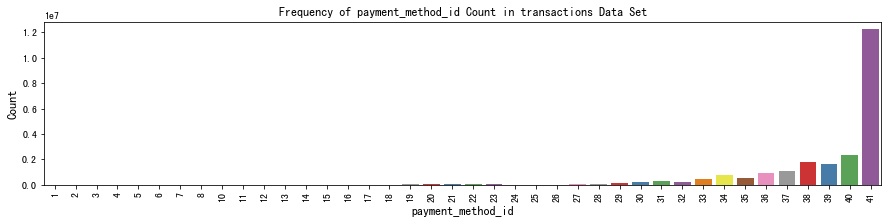

In [48]:
plt.figure(figsize=(15,3))
sns.countplot(x="payment_method_id", data=kk_transaction, palette = "Set1")
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_method_id', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of payment_method_id Count in transactions Data Set", fontsize=12)
plt.show()

* **共約55種天數方案，其中以30天(月租)的方案最常見，共約2017萬筆：**

In [49]:
# kk_transaction["payment_plan_days"].unique()

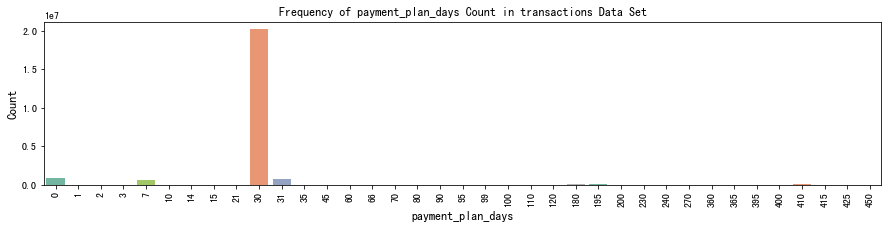

In [50]:
plt.figure(figsize=(15,3))
sns.countplot(x="payment_plan_days", data=kk_transaction, palette = "Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_plan_days', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of payment_plan_days Count in transactions Data Set", fontsize=12)
plt.show()

In [51]:
(kk_transaction["payment_plan_days"]==30).value_counts()

True     20174288
False     2804467
Name: payment_plan_days, dtype: int64

* **方案價格以149元的方案最常見：**

In [52]:
# kk_transaction["plan_list_price"].unique()

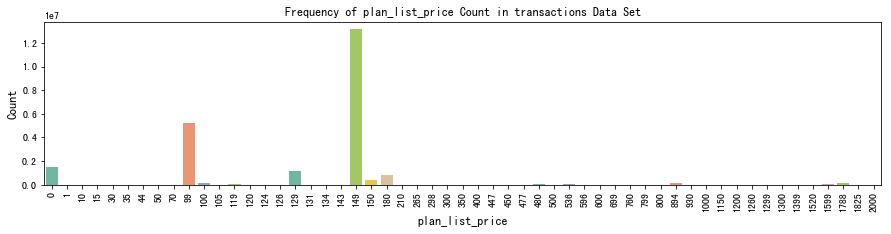

In [53]:
plt.figure(figsize=(15,3))
sns.countplot(x="plan_list_price", data=kk_transaction, palette = "Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('plan_list_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of plan_list_price Count in transactions Data Set", fontsize=12)
plt.show()

* **特徵"plan_list_price"與"actual_amount_paid"相關性達96%，故可以只看"plan_list_price"**

In [54]:
kk_transaction['plan_list_price'].corr(kk_transaction['actual_amount_paid'],method='pearson') 

0.9635363002049566

* **特徵"is_auto_renew"自動續約筆數近2000萬筆**

In [55]:
kk_transaction["is_auto_renew"].value_counts()

1    19481725
0     3497030
Name: is_auto_renew, dtype: int64

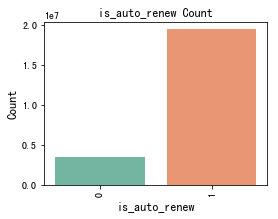

In [56]:
plt.figure(figsize=(4,3))
sns.countplot(x="is_auto_renew", data=kk_transaction, palette = "Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('is_auto_renew', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("is_auto_renew Count", fontsize=12)
plt.show()

### 小結: Transaction的msno有重複的，表示同一個人有很多次交易紀錄

## =======================================================================

### 8. 用戶聽歌紀錄_01
* **資料檔：user_logs.csv(說明：daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.)**
* 特徵A. date: format %Y%m%d
* 特徵B. num_25/50/70/100: # of songs played less than 25%/50%/70%/100% of the song length
* 特徵C. num_985: # of songs played between 75% to 98.5% of the song length
* 特徵D. total_secs:  total seconds played

In [57]:
# 檔案太大，先不取
"""
kk_userlog = pd.read_csv("user_logs.csv", sep=',',engine = 'python',iterator=True)
loop = True
chunkSize = 1000
chunks = []
index=0
while loop:
    try:
        print(index)
        chunk = kk_userlog.get_chunk(chunkSize)
        chunks.append(chunk)
        index+=1

    except StopIteration:
        loop = False
        print("Iteration is stopped.")
print('Start')
kk_userlog = pd.concat(chunks, ignore_index= True)
"""

'\nkk_userlog = pd.read_csv("user_logs.csv", sep=\',\',engine = \'python\',iterator=True)\nloop = True\nchunkSize = 1000\nchunks = []\nindex=0\nwhile loop:\n    try:\n        print(index)\n        chunk = kk_userlog.get_chunk(chunkSize)\n        chunks.append(chunk)\n        index+=1\n\n    except StopIteration:\n        loop = False\n        print("Iteration is stopped.")\nprint(\'Start\')\nkk_userlog = pd.concat(chunks, ignore_index= True)\n'

In [58]:
kk_userlog = pd.read_csv("user_logs.csv", iterator=True)

In [59]:
# 歷遍(僅能觀察資料，無法進行資料整併)
chunk = kk_userlog.get_chunk(5)
chunk

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150513,0,0,0,0,1,1,280.335
1,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150709,9,1,0,0,7,11,1658.948
2,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150105,3,3,0,0,68,36,17364.956
3,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150306,1,0,1,1,97,27,24667.317
4,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150501,3,0,0,0,38,38,9649.029


### 9. 用戶聽歌紀錄_02
* **資料檔：user_logs_v2.csv(說明：same format as user_logs.csv, refreshed 11/06/2017, contains the user logs data until 3/31/2017.)**

In [60]:
kk_userlogV2 = pd.read_csv("user_logs_v2.csv")

In [61]:
kk_userlogV2.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


* userlog的欄位特徵主要分成每個用戶聽一首歌的時間以及總時間，是否可以將總時間進行分類與流失率進行比較；或是將容易聽完整首歌的比例之類的進行分析(???

## ========================================================================

In [62]:
'''
print(f'submission01: {kk_submission01.shape}')
print(f'submission02: {kk_submission02.shape}')
print(f'members: {kk_members.shape}')
print(f'train01: {kk_train01.shape}')
print(f'train02: {kk_train02.shape}')
print(f'TrainingData: {kk_train.shape}')
print(f'transaction: {kk_transaction.shape}')
print(f'userlogV2: {kk_userlogV2.shape}')
'''

"\nprint(f'submission01: {kk_submission01.shape}')\nprint(f'submission02: {kk_submission02.shape}')\nprint(f'members: {kk_members.shape}')\nprint(f'train01: {kk_train01.shape}')\nprint(f'train02: {kk_train02.shape}')\nprint(f'TrainingData: {kk_train.shape}')\nprint(f'transaction: {kk_transaction.shape}')\nprint(f'userlogV2: {kk_userlogV2.shape}')\n"

## ====================================================

## 整理目前可以合併的部分

### A. 合併Training與Members欄位(取相同msno)

In [63]:
TrainingData = pd.merge(kk_train, kk_members, how="left", on="msno")

In [64]:
TrainingData.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,20050406.0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,20050407.0
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,20051016.0
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,20051102.0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,20051228.0


In [65]:
# 確認各欄位值是否有問題
'''
print(TrainingData["city"].unique())
print(TrainingData["bd"].unique().astype(int))
print(TrainingData["gender"].unique())
print(TrainingData["registered_via"].unique())
'''

'\nprint(TrainingData["city"].unique())\nprint(TrainingData["bd"].unique().astype(int))\nprint(TrainingData["gender"].unique())\nprint(TrainingData["registered_via"].unique())\n'

In [66]:
TrainingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963891 entries, 0 to 1963890
Data columns (total 7 columns):
msno                      object
is_churn                  int64
city                      float64
bd                        float64
gender                    object
registered_via            float64
registration_init_time    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 119.9+ MB


* **共有21個城市的客戶及各自城市的客戶數量**

In [67]:
print(TrainingData["city"].unique()) # 用戶所在城市共有21種
# print(TrainingData["city"].value_counts())  # 各城市各自有多少用戶

[18. 10. 11. 13.  3.  6.  4. 14. 22. 17.  5.  9.  1. 15. nan 12.  8.  7.
 21. 20. 16. 19.]


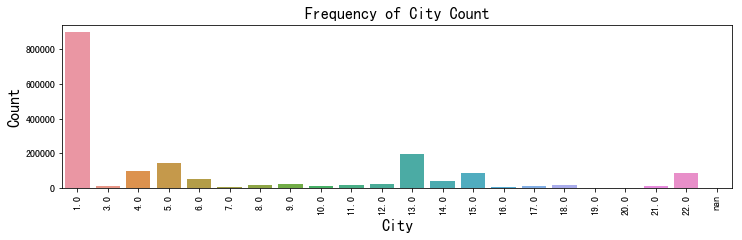

In [68]:
plt.figure(figsize=(12,3))
city_order = TrainingData['city'].unique()
city_order=sorted(city_order, key=lambda x: float(x))
sns.countplot(x="city", data=TrainingData , order = city_order)
plt.ylabel('Count', fontsize=16)
plt.xlabel('City', fontsize=16)
plt.xticks(rotation='vertical')
plt.title("Frequency of City Count", fontsize=16)
plt.show()

* **年齡的數據有點亂，可能要判斷一下是什麼格式?(Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.)**

In [69]:
TrainingData["bd"].unique().astype(int)

array([         36,          38,          27,          23,          29,
                22,          31,          43,          47,          42,
                33,          25,          28,          26,          20,
                37,          34,          16,           0,          39,
                35, -2147483648,          46,          21,          24,
                19,          40,          32,          30,          17,
                18,          44,          57,          49,          51,
               114,          41,          54,          53,          48,
                14,          45,          98,          60,          62,
                55,          56,          50,          15,          52,
                68,          58,          89,          63,          65,
               105,          72,          11,         102,          13,
                66,          61,           6,         101,          64,
                97,          59,         109,          12,      

In [70]:
TrainingData["bd"] = TrainingData.bd.apply(lambda x: -1 if float(x)<=1 else x )
TrainingData["bd"] = TrainingData.bd.apply(lambda x: -1 if float(x)>=100 else x )

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


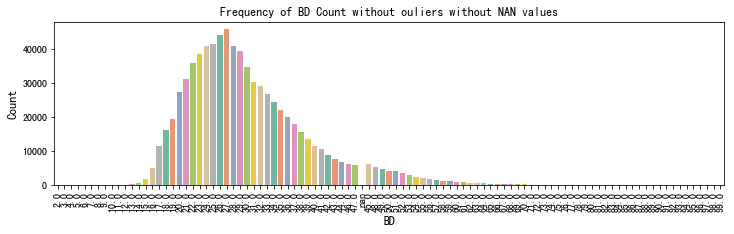

In [71]:
tmp_bd = TrainingData[(TrainingData.bd != "NaN") & (TrainingData.bd != -1)]
plt.figure(figsize=(12,3))
bd_order_2 = tmp_bd['bd'].unique()
bd_order_2 = sorted(bd_order_2, key=lambda x: float(x))
sns.countplot(x="bd", data=tmp_bd , order = bd_order_2, palette = "Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('BD', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of BD Count without ouliers without NAN values", fontsize=12)
plt.show()

* **gender(性別)以現有資料(不考慮缺失值)，男女比例差不多**

In [72]:
TrainingData["gender"].unique()

array(['female', 'male', nan], dtype=object)

In [73]:
for i in TrainingData["gender"].unique():
    genderCount = 100*(TrainingData["gender"] == i).sum() / TrainingData["gender"].size
    print(f'{i}:{genderCount:.2f}%')

female:18.83%
male:20.92%
nan:0.00%


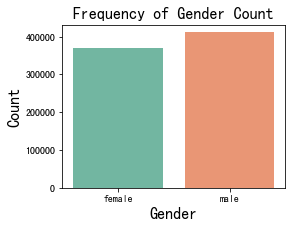

In [74]:
plt.figure(figsize=(4,3))
sns.countplot(x="gender", data=TrainingData, palette = "Set2")
plt.ylabel('Count', fontsize=16)
plt.xlabel('Gender', fontsize=16)
plt.title("Frequency of Gender Count", fontsize=16)
plt.show()

* **registered_via共有5種登入方式=>分別代表什麼???**

In [75]:
TrainingData["registered_via"].unique()

array([ 9.,  7., nan,  3.,  4., 13.])

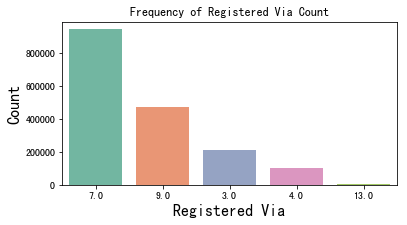

In [76]:
plt.figure(figsize=(6,3))
R_V_order = TrainingData['registered_via'].unique()
sns.countplot(x="registered_via", data=TrainingData, order=TrainingData["registered_via"].value_counts().index, palette = "Set2")
plt.ylabel('Count', fontsize=16)
plt.xlabel('Registered Via', fontsize=16)
plt.title("Frequency of Registered Via Count", fontsize=12)
plt.show()

In [77]:
TrainingData.describe().astype(np.int64)

,is_churn,city,bd,registered_via,registration_init_time
count,1963891,1738128,1738128,1738128,1738128
mean,0,5,12,6,20132461
std,0,6,16,1,29922
min,0,1,-1,3,20040326
25%,0,1,-1,7,20120212
50%,0,1,-1,7,20140523
75%,0,13,27,9,20160111
max,1,22,99,13,20170424


In [78]:
TrainingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963891 entries, 0 to 1963890
Data columns (total 7 columns):
msno                      object
is_churn                  int64
city                      float64
bd                        float64
gender                    object
registered_via            float64
registration_init_time    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 119.9+ MB


In [79]:
TrainingData.shape  # 有196萬筆資料

(1963891, 7)

In [80]:
print(100*(TrainingData.isnull().sum()/len(TrainingData))) # 各特徵missing value比例

msno                       0.000000
is_churn                   0.000000
city                      11.495699
bd                        11.495699
gender                    60.252529
registered_via            11.495699
registration_init_time    11.495699
dtype: float64


#### 小結1:  特徵"city", "bd", "gender", "registered_via", "registration_init_time"都有missing value
#### 小結2:  其中特徵"gender"達到60%的missing value

### B. 交易資訊(Transaction)整理

In [81]:
kk_transaction.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,trans_date,mem_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-09-30,2015-11-01,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,2015-09-30,2015-10-31,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,2015-09-30,2016-04-27,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,2015-09-30,2015-11-28,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,2015-09-30,2015-11-21,0


In [82]:
Transaction = kk_transaction.groupby(by='msno')['payment_plan_days','plan_list_price','is_auto_renew','is_cancel'].sum()

In [83]:
Transaction.head()

,payment_plan_days,plan_list_price,is_auto_renew,is_cancel
msno,,,,
+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,7.0,0.0,0,0
+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,805.0,3387.0,0,0
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,150.0,495.0,5,0
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,603.0,2980.0,21,0
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,780.0,3874.0,27,0


In [84]:
Transaction.shape

(2426143, 4)

In [85]:
# 合併TrainingData與Transaction
TrainingData = pd.merge(left=TrainingData, right=Transaction ,how='left',on=['msno'])

In [86]:
TrainingData.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_plan_days,plan_list_price,is_auto_renew,is_cancel
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,20050406.0,37.0,149.0,0,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,20050407.0,663.0,3309.0,22,2
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,20051016.0,300.0,1492.0,8,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,20051102.0,850.0,1937.0,1,0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,20051228.0,875.0,4053.0,0,0


In [87]:
TrainingData.shape

(1963891, 11)

### ※特徵觀察整理
#### Submission & Train-----
* 特徵1. 流失(is_churn)；型態int：流失值為y值。Submission作為測試集主要針對2017年3月退訂的客戶，於2017年4月是否續訂?Training Data則是2017年2月以前退訂，且30天內有無訂閱動作做為流失判定。Training Data的流失/續訂比差異較大(超過1:10)。
#### Members-----
* 特徵2. 用戶所在地區(city)；型態int(one-hot encode)：依目前觀察到的應有21個城市，但是沒有詳細說明哪些城市(且都以編碼表示)，只能進行分類以及各自城市用戶數有多少。
* 特徵3. 年齡(bd)；型態float：年齡的數據有點亂，必須要篩掉一些不合理值。
* 特徵4. 性別(gender)；型態string(male or female)：性別的缺失值最多，達到約60%，可能要考慮如何處理缺失值。
* 特徵5. 登入方式(registered_via)；型態(one-hot encode)：共有5種登入方式，沒有特別說明，可能是不同的裝置。
* 特徵6. 初始創建帳號日期(registration_init_time)；型態string：或許可以比較老用戶與新用戶流失值，以及比較聽歌時間的影響。
#### 交易紀錄-----
* 特徵7. 付款方式(payment_method_id)；型態int(one-hot encode)：交易付款方式都是以代號顯示，只能做分類(或許可以針對現有的付款方式去兜看看)。
* 特徵8. 一次付款方案天數(payment_plan_days)；型態int：以天數為單位，觀察資料以30天為最多(月租)。
* 特徵9. 計畫方案價格(plan_list_price)；型態int(NTD)：應該與方案天數有高度相關(?
* 特徵10. 實際付費價格(actual_amount_paid)；型態int(NTD)：與特徵9應該高度相關(重合?
* 特徵11. 自動續約(is_auto_renew)；型態int(0 or 1)
* 特徵12+13. 交易日期(transaction_date)&退訂或合約到期日(membership_expire_date)：若這兩者日期相減等同合約日期則表示合約到期；如相減不等於合約到期，則表示客戶提前退訂，可以觀察是否影響到後續流失率(30天內不再續訂)。
* 特徵14. 取消(is_cancel)；型態int(0 or 1)：客戶是否自動退訂，客戶自動退訂不等於流失(因為本資料流失的定義為退訂後30天沒有任何交易資料才算，所以有可能客戶退訂是為了要訂其他不同天方案。
#### 用戶紀錄(聽歌)-----
* 特徵15. 用戶聽歌完整度(num_25/50/70/985/100)；型態int(次數)：98.5%應該可以與100%完整聽完一樣意思(合併?)；聽不到25%的比例多的話是否代表沒有喜歡聽的類型，可能與流失值有關(?
* 特徵16. num_unq：沒有說明。
* 特徵17. 總聽歌長度(total_secs)；型態int：可以與註冊時間長短比例做比較來確認與流失值的關係(?
* 特徵18. 用戶id(msno)；型態string：可以拿來在不同資料做欄位對應。

In [88]:
Character = {"特徵":["流失(is_churn)","用戶id","city",]}

## ====================================================

### 先針對members與train做base model訓練

### 置換缺失值

In [89]:
# 城市缺失值置換成-1
TrainingData["city"] = TrainingData.city.fillna(-1)
# 年齡缺失值置換成-1
TrainingData["bd"] = TrainingData.bd.fillna(-1)
# 註冊時間以datetime型態顯示
TrainingData['registration_init_time'] = TrainingData.registration_init_time.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN" )
# 性別置換為男->1, 女->2
TrainingData["gender"] = TrainingData.gender.fillna(-1)
TrainingData["gender"].replace("male", 1, inplace=True)
TrainingData["gender"].replace("female", 2, inplace=True)
# 註冊方式缺失值置換成-1
TrainingData["registered_via"] = TrainingData.registered_via.fillna(-1)

In [90]:
TrainingData.rename(columns={'payment_plan_days':'total_paymentDays', 'plan_list_price':'totalPrice'},inplace=True)
TrainingData.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,total_paymentDays,totalPrice,is_auto_renew,is_cancel
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,2,9.0,2005-04-06,37.0,149.0,0,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,1,9.0,2005-04-07,663.0,3309.0,22,2
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,2,9.0,2005-10-16,300.0,1492.0,8,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,2,9.0,2005-11-02,850.0,1937.0,1,0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,1,9.0,2005-12-28,875.0,4053.0,0,0


In [91]:
print(TrainingData["city"].unique())
print(TrainingData["bd"].unique().astype(int))
print(TrainingData["gender"].unique())
print(TrainingData["registered_via"].unique())

[18. 10. 11. 13.  3.  6.  4. 14. 22. 17.  5.  9.  1. 15. -1. 12.  8.  7.
 21. 20. 16. 19.]
[36 38 27 23 29 22 31 43 47 42 33 25 28 26 20 37 34 16 -1 39 35 46 21 24
 19 40 32 30 17 18 44 57 49 51 41 54 53 48 14 45 98 60 62 55 56 50 15 52
 68 58 89 63 65 72 11 13 66 61  6 64 97 59 12 83 92 94 67 75 69  3 79 81
  7 70 77  2 71 91 73  4 76 99 96 74 95 90 80 78 10  8 86 84 85 82  9  5
 93 88 87]
[ 2  1 -1]
[ 9.  7. -1.  3.  4. 13.]


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


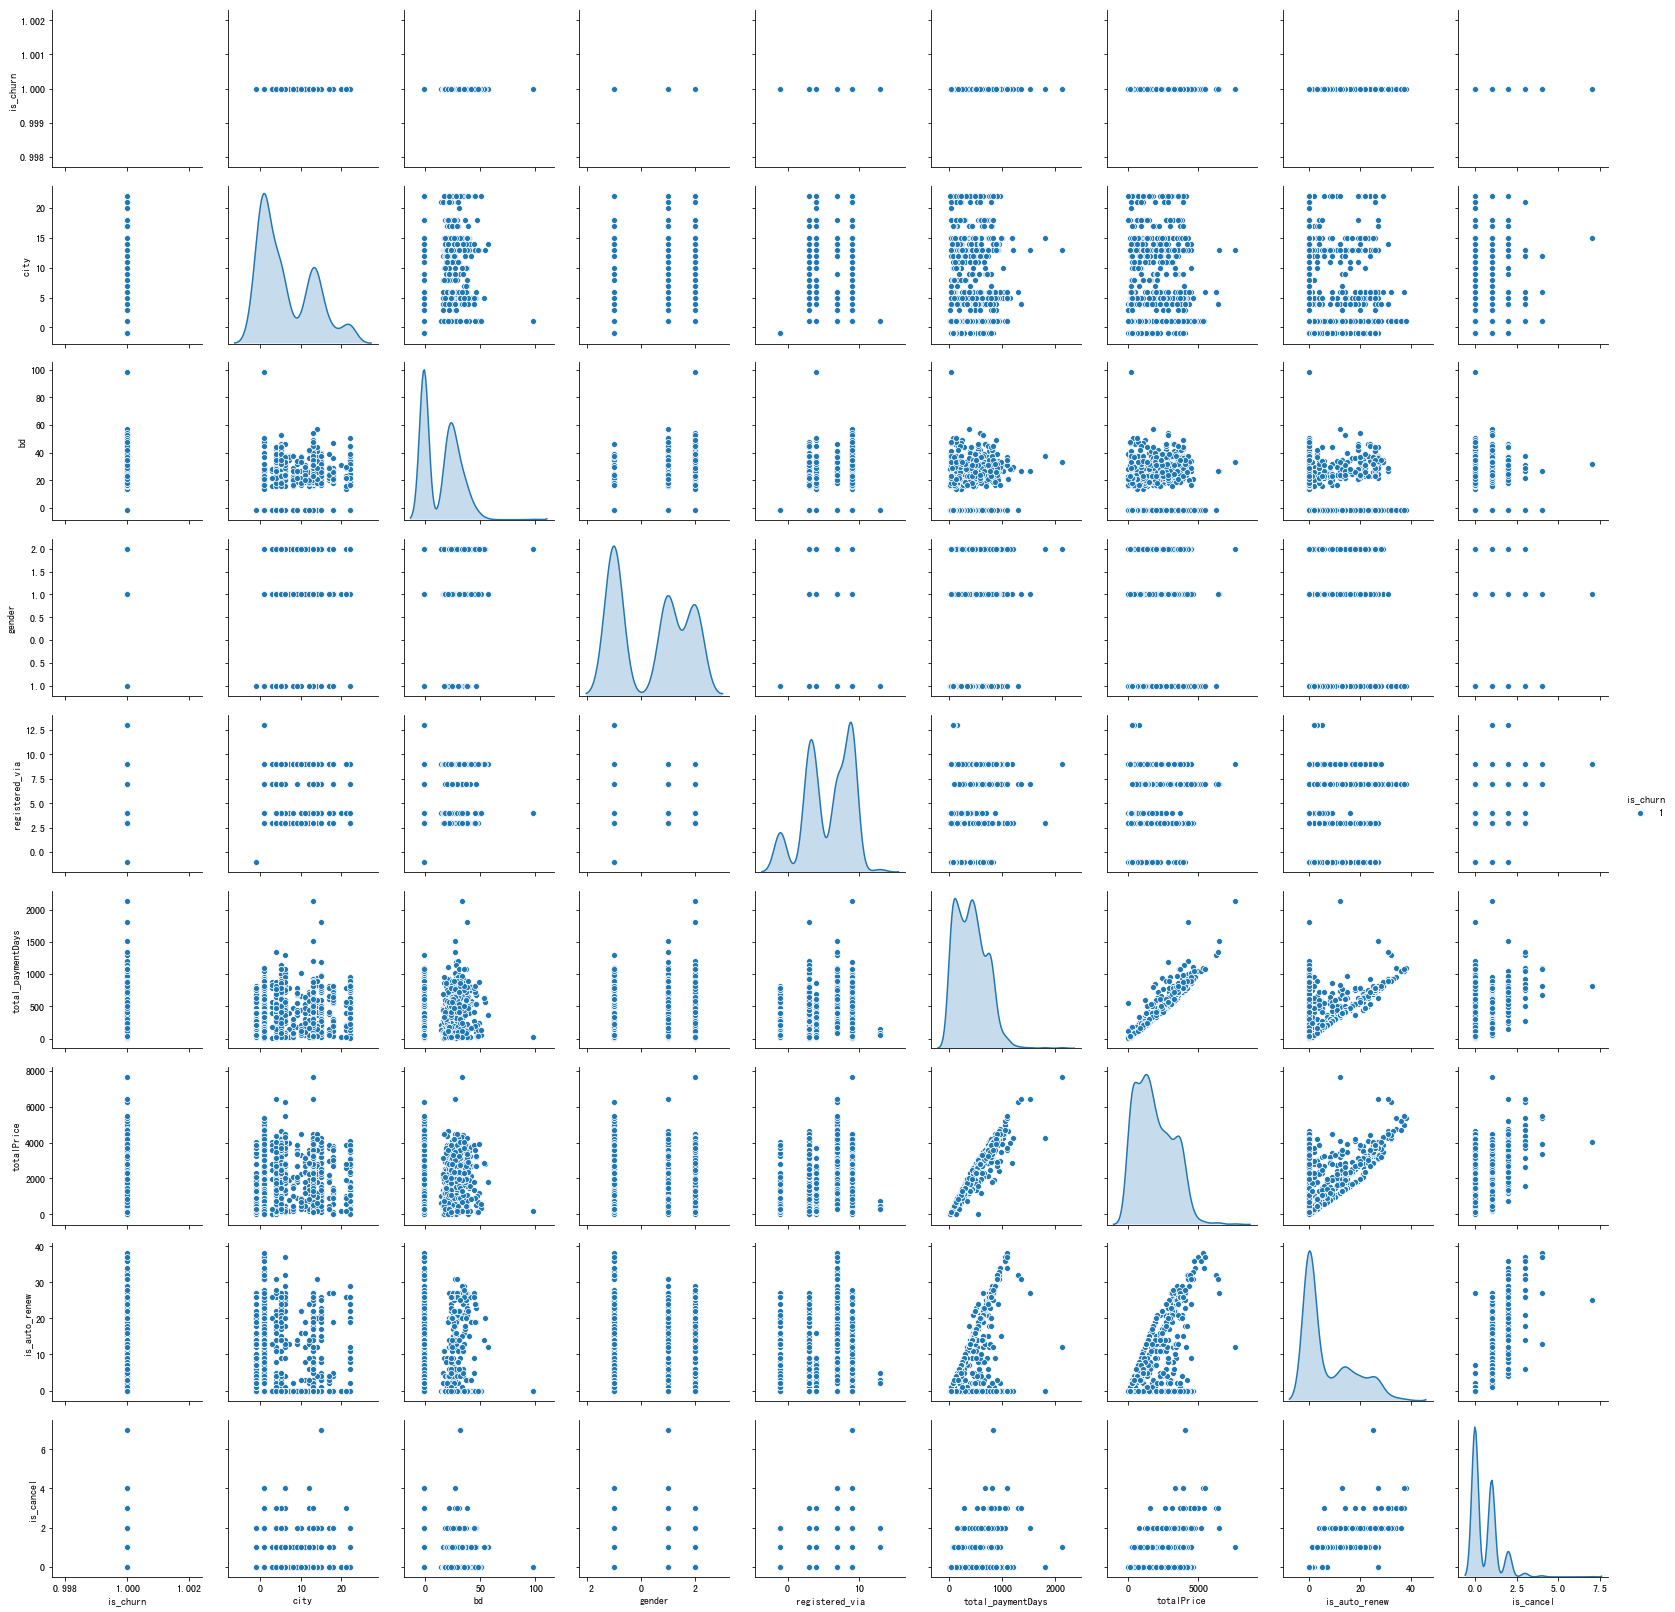

In [92]:
sns.pairplot(hue="is_churn", data=TrainingData.iloc[:1000, [1,2,3,4,5,7,8,9,10]])

## 切割訓練集與驗證集

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
X = TrainingData.iloc[:, [2,3,4,5,7,8,9,10]].values
y = TrainingData.iloc[:, 1].values

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

* **流失(churn)與非流失(Not churn)比例懸殊，是否需要調整欄位?**

In [96]:
print("Training的流失與未流失個數")
print("="*20)
print((y_train == 1).sum())
print((y_train == 0).sum())
print("\n")
print("Testing的流失與未流失個數")
print("="*20)
print((y_test == 1).sum())
print((y_test == 0).sum())

Training的流失與未流失個數
105477
1269246


Testing的流失與未流失個數
45324
543844


## Model01_Try(Random Forest)

In [97]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
RFClassifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)

In [99]:
RFClassifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [100]:
RFClassifier.score(X=X_train, y=y_train)

0.9674581715734734

In [101]:
y_predRF = RFClassifier.predict(X_test)

In [102]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predRF)
cm

array([[530900,  12944],
       [ 24929,  20395]], dtype=int64)

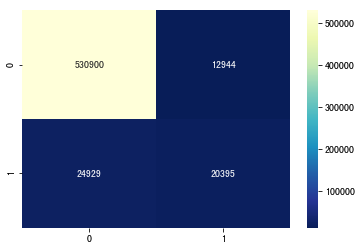

In [103]:
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")

In [104]:
from sklearn import metrics
report = metrics.classification_report(y_test, y_predRF)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    543844
           1       0.61      0.45      0.52     45324

   micro avg       0.94      0.94      0.94    589168
   macro avg       0.78      0.71      0.74    589168
weighted avg       0.93      0.94      0.93    589168



In [105]:
# 精準率
print(metrics.accuracy_score(y_test, y_predRF))
# 預測為正，實際為正
print(metrics.precision_score(y_test, y_predRF))
# 實際為正，預測為正
print(metrics.recall_score(y_test, y_predRF))

0.9357178258153871
0.6117460031794595
0.4499823493072103


## Model02_Try(LinearSVC)

In [106]:
from sklearn.svm import SVC, LinearSVC

In [107]:
SVC1 = LinearSVC(random_state=555)

In [108]:
SVC1.fit(X=X_train, y=y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=555, tol=0.0001,
     verbose=0)

In [109]:
SVC1.score(X=X_train, y=y_train)

0.9068597819342514

In [110]:
y_predSVC1 = SVC1.predict(X_test)

In [111]:
cm1 = confusion_matrix(y_test, y_predSVC1)
cm1

array([[511934,  31910],
       [ 22989,  22335]], dtype=int64)

In [112]:
report1 = metrics.classification_report(y_test, y_predSVC1)
print(report1)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95    543844
           1       0.41      0.49      0.45     45324

   micro avg       0.91      0.91      0.91    589168
   macro avg       0.68      0.72      0.70    589168
weighted avg       0.92      0.91      0.91    589168



In [113]:
# 精準率
print(metrics.accuracy_score(y_test, y_predSVC1))
# 預測為正，實際為正
print(metrics.precision_score(y_test, y_predSVC1))
# 實際為正，預測為正
print(metrics.recall_score(y_test, y_predSVC1))

0.9068194470847025
0.41174301778965805
0.4927852793222134


## Model03_Try(SVC)

In [114]:
# SVC2 = SVC(probability=True, random_state=555)

In [115]:
# SVC2.fit(X=X_train, y=y_train)

In [116]:
# SVC2.score(X=X_train, y=y_train)

In [117]:
# y_predSVC2 = SVC2.predict(X_test)

In [118]:
# cm2 = confusion_matrix(y_test, y_predSVC2)
# cm2

In [119]:
# 精準率
# print(metrics.accuracy_score(y_test, y_predSVC2))
# 預測為正，實際為正
# print(metrics.precision_score(y_test, y_predSVC2))
# 實際為正，預測為正
# print(metrics.recall_score(y_test, y_predSVC2))

### FPR,TPR

In [120]:
score_y1 = SVC1.decision_function(X)
# score_y2 = SVC2.decision_function(X)

In [121]:
n_classes = 2

In [122]:
linear_svc = pd.DataFrame()
# rbf_svc = pd.DataFrame()
for i in range(n_classes):
    fpr = "fpr_cls_{}".format(i)
    tpr = "tpr_cls_{}".format(i)
    linear_svc[fpr], linear_svc[tpr], _ = metrics.roc_curve(y, score_y1)
#     fpr = "fpr_cls_{}".format(i)
#     tpr = "tpr_cls_{}".format(i)
#     rbf_svc[fpr], rbf_svc[tpr], _ = metrics.roc_curve(y, score_y2)

### ROC Curve

KeyboardInterrupt: 

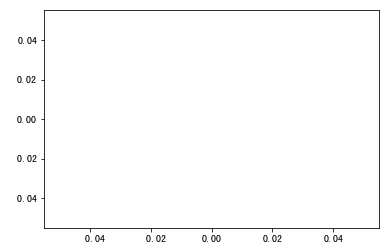

In [123]:
sns.lineplot(x="fpr_cls_0", y="tpr_cls_0", data=linear_svc)
# sns.lineplot(x="fpr_cls_0", y="tpr_cls_0", data=rbf_svc)

In [ ]:
print(metrics.auc(linear_svc["fpr_cls_0"], linear_svc["tpr_cls_0"]))
print(metrics.auc(linear_svc["fpr_cls_1"], linear_svc["tpr_cls_1"]))